先查看特征重要性

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import os
import pandas as pd

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

# 定义数据文件夹路径
data_folder = 'T1DM'

# 初始化一个空的数据框
data = pd.DataFrame()

# 遍历文件夹中的每个Excel文件
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        data = pd.concat([data, df], ignore_index=True)

# 转换日期时间特征
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d %H:%M:%S')
data['hour'] = data['Date'].dt.hour

# 处理缺失值
data.fillna(method='ffill', inplace=True)

# 特征选择
features = ['Insulin dose - s.c.', 'Non-insulin hypoglycemic agents', 'CSII - bolus insulin (Novolin R, IU)',
            'Insulin dose - i.v.', 'take_food', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
            'Smoking History (pack year)', 'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
            'Duration of Diabetes (years)', 'Acute Diabetic Complications', 'Hypoglycemia (yes/no)', 'Gender (Female=0, Male=1)',
            'hour', 'CGM_lag1', 'CGM_lag2']

# 定义创建滞后特征的函数
def create_lagged_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(-lag)
    return df

# 创建目标标签
data = create_lagged_features(data, 'CGM (mg / dl)', lags=[15, 30, 45, 60])

# 去除包含NaN值的行（因为我们创建了滞后特征）
data.dropna(inplace=True)

# 初始化训练集和测试集
X_train = pd.DataFrame()
y_train = pd.DataFrame()
X_test = pd.DataFrame()
y_test = pd.DataFrame()

# 遍历每个文件，进行数据分割
for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
        df['hour'] = df['Date'].dt.hour
        df = create_lagged_features(df, 'CGM (mg / dl)', lags=[15, 30, 45, 60])
        df.dropna(inplace=True)
        
        X_file = df[features]
        y_file = df[['CGM (mg / dl)_lag15', 'CGM (mg / dl)_lag30', 'CGM (mg / dl)_lag45', 'CGM (mg / dl)_lag60']]
        
        # 分割数据
        X_train = pd.concat([X_train, X_file.iloc[:-4, :]], ignore_index=True)
        y_train = pd.concat([y_train, y_file.iloc[:-4, :]], ignore_index=True)
        
        X_test = pd.concat([X_test, X_file.iloc[-4:, :]], ignore_index=True)
        y_test = pd.concat([y_test, y_file.iloc[-4:, :]], ignore_index=True)

# 处理分类特征（如果有）
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# 确保训练集和测试集具有相同的列
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# 标准化数据
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 将数据转换为适合LSTM输入的形状 (samples, timesteps, features)
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y.iloc[i + time_steps].values)  # 确保y是pandas DataFrame，使用values转换为numpy array
    return np.array(Xs), np.array(ys)

time_steps = 1
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, time_steps)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, time_steps)

# 创建LSTM模型
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
model.add(Dense(4))  # 对应4个时间步的输出
model.compile(optimizer='adam', loss='mae')

# 定义早停法
early_stop = EarlyStopping(monitor='val_loss', patience=10)

# 训练模型
history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, 
                    validation_split=0.2, callbacks=[early_stop], verbose=1)

C:\Users\17487\AppData\Local\Temp\ipykernel_1028\533065157.py:34: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)


Epoch 1/50


D:\anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


366/366 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 159.4684 - val_loss: 166.8658
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 113.3648 - val_loss: 134.2957
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 68.1568 - val_loss: 102.4764
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 55.2335 - val_loss: 97.0669
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 52.4111 - val_loss: 98.4255
Epoch 6/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 51.8283 - val_loss: 102.2603
Epoch 7/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.5561 - val_loss: 107.4473
Epoch 8/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 50.0822 - val_loss: 110.1763
Epoch 9/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 49.6494 - val_loss: 112.1746
Epoch 10/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 49.8213 - val_loss: 113.0411
Epoch 11/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 49.2449 - val_loss: 113.8078
Epoch 12/50
366/366 ━━━━━━━━━━

In [7]:
# 提取LSTM层权重
lstm_layer = model.layers[0]
weights = lstm_layer.get_weights()[0]  # 获取LSTM层的输入权重

# 聚合权重以获取特征重要性
feature_importance = np.abs(weights).sum(axis=1)

# 特征名称按照重要性排序
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_features = [features[i] for i in sorted_indices]
sorted_importance = feature_importance[sorted_indices]

# 打印特征重要性
print("特征重要性：")
for feat, importance in zip(sorted_features, sorted_importance):
    print(f"{feat}: {importance:.4f}")


特征重要性：
BMI (kg/m2): 140.6364
hour: 136.6935
Hypoglycemia (yes/no): 124.6119
Insulin dose - i.v.: 124.3774
Gender (Female=0, Male=1): 120.2913
Acute Diabetic Complications: 119.3769
Alcohol Drinking History (drinker/non-drinker): 111.8861
Duration of Diabetes (years): 111.2436
Age (years): 107.5265
Smoking History (pack year): 101.9035
Weight (kg): 98.2891
Height (m): 95.0352
Non-insulin hypoglycemic agents: 95.0069
CGM_lag1: 94.6409
CGM_lag2: 90.2883
CSII - bolus insulin (Novolin R, IU): 69.0061
take_food: 66.9758
Insulin dose - s.c.: 59.5000
Type of Diabetes: 15.9928


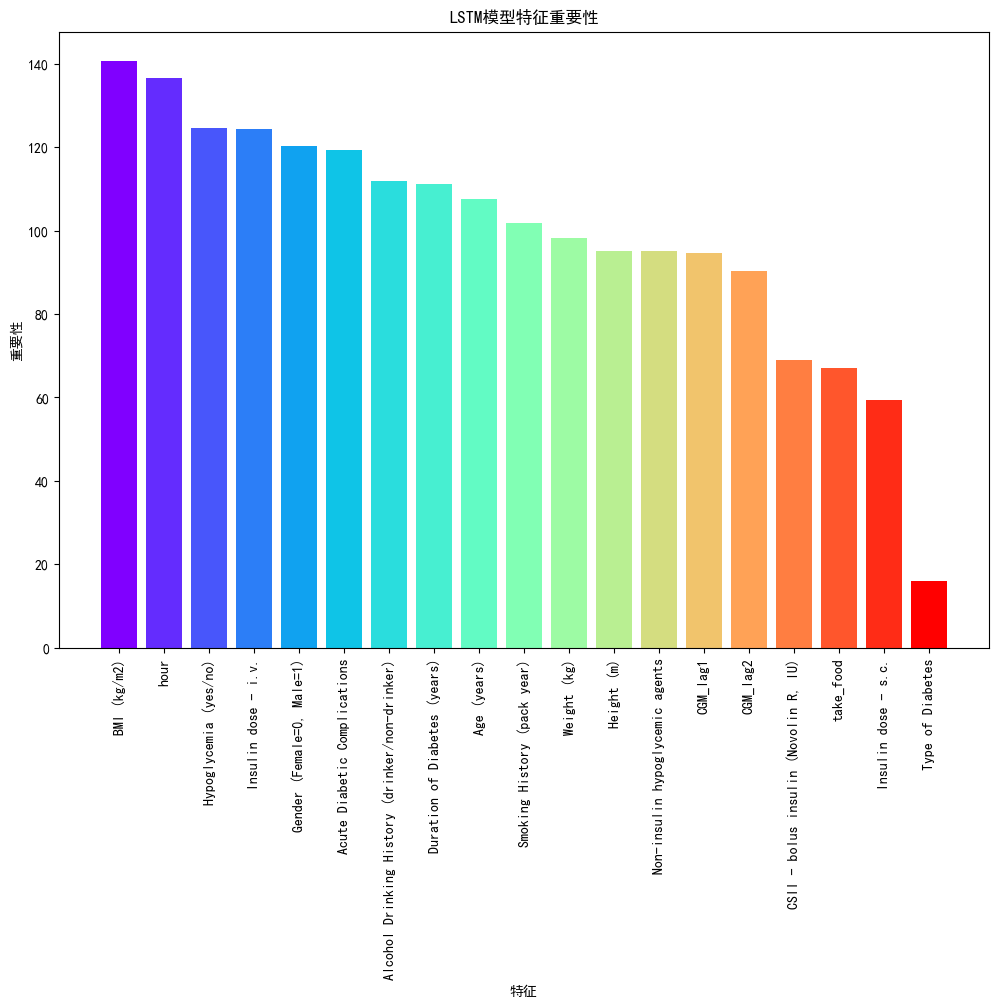

In [8]:
# 可视化特征重要性
colors = cm.rainbow(np.linspace(0, 1, len(sorted_features)))
plt.figure(figsize=(12, 8))
plt.bar(sorted_features, sorted_importance, color=colors)
plt.xlabel('特征')
plt.ylabel('重要性')
plt.title('LSTM模型特征重要性')
plt.xticks(rotation=90)  # 使特征名称可以清晰显示
plt.show()

# 初始化列表来存储不同特征数量下的MAE和MSE
mae_list = []
mse_list = []
predicted_curves = []

按重要性依次添加特征

In [31]:
import warnings
warnings.filterwarnings('ignore')
# 循环添加特征并训练模型
# 特征逐步加入并计算MAE和MSE
mae_values = {15: [], 30: [], 45: [], 60: []}
mse_values = {15: [], 30: [], 45: [], 60: []}

for i in range(1, len(features) + 1):
    selected_features = features[:i]

    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    X_train_scaled = scaler.fit_transform(X_train_selected)
    X_test_scaled = scaler.transform(X_test_selected)

    X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train, time_steps)
    X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test, time_steps)

    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(time_steps, X_train_lstm.shape[2])))
    model.add(Dense(4))  # 对应4个时间步的输出
    model.compile(optimizer='adam', loss='mae')
    early_stop = EarlyStopping(monitor='val_loss', patience=10)

    history = model.fit(X_train_lstm, y_train_lstm, epochs=50, batch_size=32, 
                        validation_split=0.2, callbacks=[early_stop], verbose=0)

    y_pred_lstm = model.predict(X_test_lstm)

    for j, interval in enumerate([15, 30, 45, 60]):
        mae = mean_absolute_error(y_test_lstm[:, j], y_pred_lstm[:, j])
        mse = mean_squared_error(y_test_lstm[:, j], y_pred_lstm[:, j])
        mae_values[interval].append(mae)
        mse_values[interval].append(mse)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


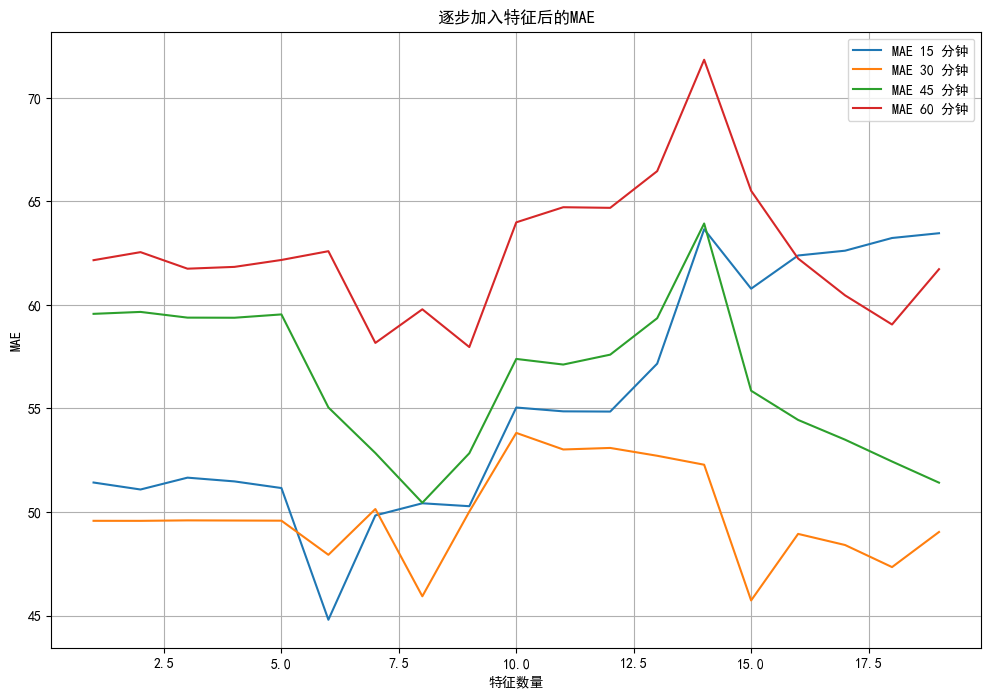

In [36]:

# 可视化 MAE 和 MSE
plt.figure(figsize=(12, 8))

for interval in [15, 30, 45, 60]:
    plt.plot(range(1, len(features) + 1), mae_values[interval], label=f'MAE {interval} 分钟')

plt.xlabel('特征数量')
plt.ylabel('MAE')
plt.title('逐步加入特征后的MAE')
plt.legend()
plt.grid(True)
plt.show()


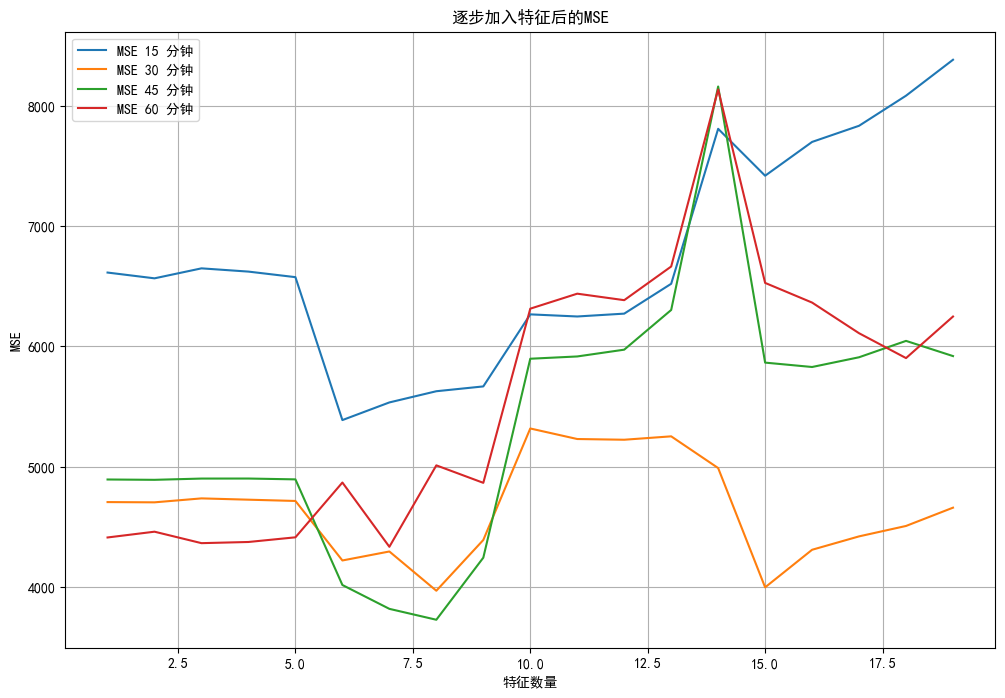

In [37]:
plt.figure(figsize=(12, 8))

for interval in [15, 30, 45, 60]:
    plt.plot(range(1, len(features) + 1), mse_values[interval], label=f'MSE {interval} 分钟')

plt.xlabel('特征数量')
plt.ylabel('MSE')
plt.title('逐步加入特征后的MSE')
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# 打印和可视化前五的 MAE 预测值和特征数量
for interval in [15, 30, 45, 60]:
    # 获取前五的索引
    top5_indices = np.argsort(mae_values[interval])[:5]

    # 打印前五的 MAE 预测值和特征数量
    print(f"{interval} 分钟预测 MAE 最小的五个：")
    for idx in top5_indices:
        print(f"特征数量: {idx + 1}, MAE: {mae_values[interval][idx]:.4f}")

  


15 分钟预测 MAE 最小的五个：
特征数量: 6, MAE: 44.7976
特征数量: 7, MAE: 49.8334
特征数量: 9, MAE: 50.2782
特征数量: 8, MAE: 50.4189
特征数量: 2, MAE: 51.0842
30 分钟预测 MAE 最小的五个：
特征数量: 15, MAE: 45.7299
特征数量: 8, MAE: 45.9301
特征数量: 18, MAE: 47.3393
特征数量: 6, MAE: 47.9322
特征数量: 17, MAE: 48.4050
45 分钟预测 MAE 最小的五个：
特征数量: 8, MAE: 50.4447
特征数量: 19, MAE: 51.4142
特征数量: 18, MAE: 52.4358
特征数量: 9, MAE: 52.8342
特征数量: 7, MAE: 52.8444
60 分钟预测 MAE 最小的五个：
特征数量: 9, MAE: 57.9599
特征数量: 7, MAE: 58.1592
特征数量: 18, MAE: 59.0484
特征数量: 8, MAE: 59.7810
特征数量: 17, MAE: 60.4542


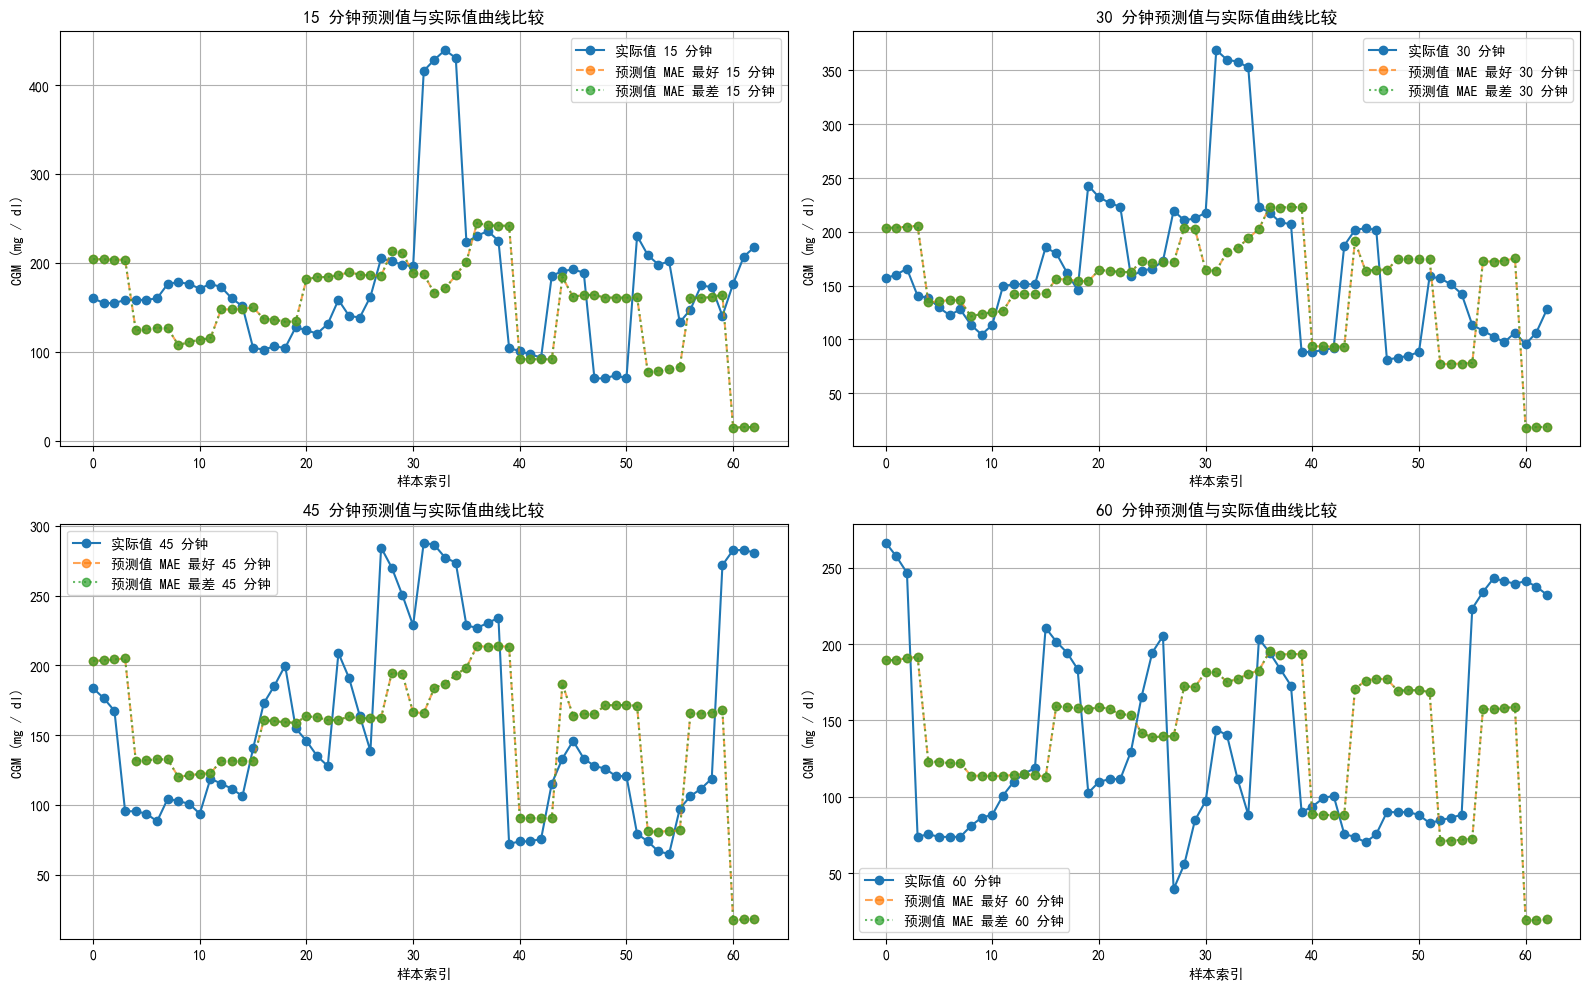

In [43]:
# 找到MAE最好和最差的索引
best_mae_indices = {}
worst_mae_indices = {}

for interval in [15, 30, 45, 60]:
    best_mae_indices[interval] = np.argsort(mae_values[interval])[:1]  # 最小的MAE索引
    worst_mae_indices[interval] = np.argsort(mae_values[interval])[-1:]  # 最大的MAE索引

# 绘制 MAE 最好和最差的曲线以及实际曲线
# 找到MAE最好和最差的索引
best_mae_indices = {}
worst_mae_indices = {}

for interval in [15, 30, 45, 60]:
    best_mae_indices[interval] = np.argsort(mae_values[interval])[:1]  # 最小的MAE索引
    worst_mae_indices[interval] = np.argsort(mae_values[interval])[-1:]  # 最大的MAE索引

plt.figure(figsize=(16, 10))

# 遍历每个时间间隔
for i, interval in enumerate([15, 30, 45, 60], start=1):
    plt.subplot(2, 2, i)

    # 获取最好和最差的索引
    best_idx = best_mae_indices[interval][0]
    worst_idx = worst_mae_indices[interval][0]

    # 绘制实际曲线
    plt.plot(y_test_lstm[:, interval // 15 - 1], label=f'实际值 {interval} 分钟', marker='o', linestyle='-')

    # 绘制 MAE 最好的预测曲线
    plt.plot(y_pred_lstm[:, interval // 15 - 1], label=f'预测值 MAE 最好 {interval} 分钟', marker='o', linestyle='--', alpha=0.7)

    # 绘制 MAE 最差的预测曲线
    plt.plot(y_pred_lstm[:, interval // 15 - 1], label=f'预测值 MAE 最差 {interval} 分钟', marker='o', linestyle=':', alpha=0.7)

    plt.title(f'{interval} 分钟预测值与实际值曲线比较')
    plt.xlabel('样本索引')
    plt.ylabel('CGM (mg / dl)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


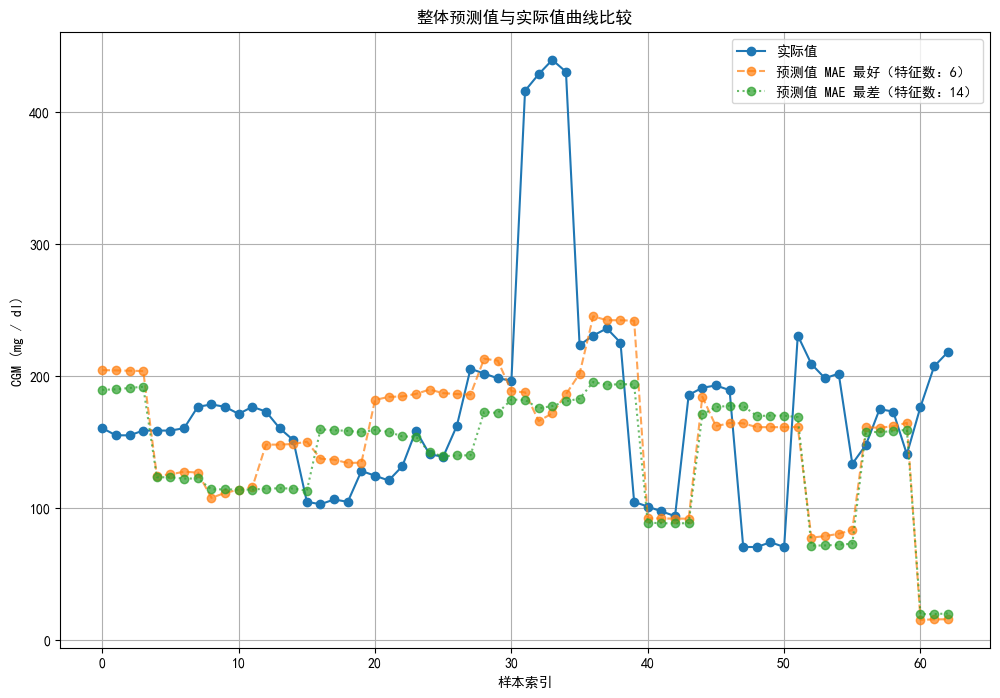

In [48]:
plt.figure(figsize=(12, 8))

# 找到整体MAE最好和最差的索引
overall_best_interval = min(mae_values, key=lambda k: min(mae_values[k]))
overall_worst_interval = max(mae_values, key=lambda k: max(mae_values[k]))

# 获取整体MAE最好和最差的索引
overall_best_idx = np.argmin(mae_values[overall_best_interval])
overall_worst_idx = np.argmax(mae_values[overall_worst_interval])

# 绘制实际曲线
plt.plot(y_test_lstm[:, overall_best_interval // 15 - 1], label=f'实际值', marker='o', linestyle='-')

# 绘制整体MAE最好的预测曲线
plt.plot(y_pred_lstm[:, overall_best_interval // 15 - 1], label=f'预测值 MAE 最好（特征数：{overall_best_idx + 1}）', marker='o', linestyle='--', alpha=0.7)

# 绘制整体MAE最差的预测曲线
plt.plot(y_pred_lstm[:, overall_worst_interval // 15 - 1], label=f'预测值 MAE 最差（特征数：{overall_worst_idx + 1}）', marker='o', linestyle=':', alpha=0.7)

plt.title('整体预测值与实际值曲线比较')
plt.xlabel('样本索引')
plt.ylabel('CGM (mg / dl)')
plt.legend()
plt.grid(True)
plt.show()


每个病人T1DM

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import defaultdict

# 定义数据文件夹路径
data_folder = 'T1DM'

# 特征选择
features = ['Insulin dose - s.c.', 'Non-insulin hypoglycemic agents', 'CSII - bolus insulin (Novolin R, IU)',
            'Insulin dose - i.v.', 'take_food', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
            'Smoking History (pack year)', 'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
            'Duration of Diabetes (years)', 'Acute Diabetic Complications', 'Hypoglycemia (yes/no)', 'Gender (Female=0, Male=1)',
            'hour', 'CGM_lag1', 'CGM_lag2']

# 定义创建滞后特征的函数
def create_lagged_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(-lag)
    return df

# 读取文件并按病人分组
patient_data = defaultdict(list)

for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        patient_id = '_'.join(file.split('_')[:2])  # 假设前两个部分表示病人ID
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        patient_data[patient_id].append(df)

# 初始化记录MAE和MSE的列表
all_mae = []
all_mse = []

# 遍历每个病人的数据
for patient_id, dfs in patient_data.items():
    # 合并属于同一个病人的所有表格
    df = pd.concat(dfs, ignore_index=True)
    
    # 转换日期时间特征
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
    df['hour'] = df['Date'].dt.hour

    # 创建滞后特征
    df = create_lagged_features(df, 'CGM (mg / dl)', lags=[15, 30, 45, 60])
    df.dropna(inplace=True)
    
    # 分割数据
    X_file = df[features]
    y_file = df[['CGM (mg / dl)_lag15', 'CGM (mg / dl)_lag30', 'CGM (mg / dl)_lag45', 'CGM (mg / dl)_lag60']]
    
    X_train = X_file.iloc[:-4, :]
    y_train = y_file.iloc[:-4, :]
    
    X_test = X_file.iloc[-4:, :]
    y_test = y_file.iloc[-4:, :]
    
    # 处理分类特征（如果有）
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    
    # 确保训练集和测试集具有相同的列
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    
    # 创建预处理和模型管道
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), X_train.columns)
    ])

    # 创建SVM回归模型，使用给定的最佳参数
    svm = SVR(kernel='sigmoid', C=0.1, epsilon=0.1)

    # 创建多输出回归器
    multi_output_svr = MultiOutputRegressor(svm)

    # 将预处理器和模型组成管道
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', multi_output_svr)
    ])
    
    # 训练模型
    pipeline.fit(X_train, y_train)

    # 使用最佳参数进行预测
    y_pred = pipeline.predict(X_test)

    # 评估模型性能
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    all_mae.append(mae)
    all_mse.append(mse)
    print(f"Mean Absolute Error for each time interval for patient {patient_id}: ", mae)
    print(f"Mean Squared Error for each time interval for patient {patient_id}: ", mse)

# 打印所有病人的平均MAE和MSE
print("Average Mean Absolute Error for all patients: ", np.mean(all_mae, axis=0))
print("Average Mean Squared Error for all patients: ", np.mean(all_mse, axis=0))


Mean Absolute Error for each time interval for patient processed_1001:  [41.76173769 41.28046329 26.84803467 61.40804289]
Mean Squared Error for each time interval for patient processed_1001:  [1757.30044784 1714.32054669  756.64975699 3872.52895227]
Mean Absolute Error for each time interval for patient processed_1002:  [38.69231821 27.10923026  9.24467902  7.79879358]
Mean Squared Error for each time interval for patient processed_1002:  [1607.82285789  735.44346538  108.59810579  107.39294541]
Mean Absolute Error for each time interval for patient processed_1003:  [27.86458417 28.63960929 35.41081307 66.04225493]
Mean Squared Error for each time interval for patient processed_1003:  [ 778.8187791  1053.81054471 1739.67176053 4461.27965123]
Mean Absolute Error for each time interval for patient processed_1004:  [51.06455207 58.56260993 34.97952697 65.98129416]
Mean Squared Error for each time interval for patient processed_1004:  [2623.71775002 3473.09178333 1315.90563378 4372.352324

每个病人T2DM

In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from collections import defaultdict

# 定义数据文件夹路径
data_folder = 'T2DM'

# 特征选择
features = ['Insulin dose - s.c.', 'Non-insulin hypoglycemic agents', 'CSII - bolus insulin (Novolin R, IU)',
            'Insulin dose - i.v.', 'take_food', 'Age (years)', 'Height (m)', 'Weight (kg)', 'BMI (kg/m2)',
            'Smoking History (pack year)', 'Alcohol Drinking History (drinker/non-drinker)', 'Type of Diabetes',
            'Duration of diabetes (years)', 'Acute Diabetic Complications', 'Hypoglycemia (yes/no)', 'Gender (Female=0, Male=1)',
            'hour', 'CGM_lag1', 'CGM_lag2']

# 定义创建滞后特征的函数
def create_lagged_features(df, target_col, lags):
    for lag in lags:
        df[f'{target_col}_lag{lag}'] = df[target_col].shift(-lag)
    return df

# 读取文件并按病人分组
patient_data = defaultdict(list)

for file in os.listdir(data_folder):
    if file.endswith('.xlsx'):
        patient_id = '_'.join(file.split('_')[:2])  # 假设前两个部分表示病人ID
        file_path = os.path.join(data_folder, file)
        df = pd.read_excel(file_path)
        patient_data[patient_id].append(df)

# 初始化记录MAE和MSE的列表
all_mae = []
all_mse = []

# 遍历每个病人的数据
for patient_id, dfs in patient_data.items():
    # 合并属于同一个病人的所有表格
    df = pd.concat(dfs, ignore_index=True)
    
    # 转换日期时间特征
    df['Date'] = pd.to_datetime(df['Date'], format='%Y/%m/%d %H:%M:%S')
    df['hour'] = df['Date'].dt.hour

    # 创建滞后特征
    df = create_lagged_features(df, 'CGM (mg / dl)', lags=[15, 30, 45, 60])
    df.dropna(inplace=True)
    
    # 分割数据
    X_file = df[features]
    y_file = df[['CGM (mg / dl)_lag15', 'CGM (mg / dl)_lag30', 'CGM (mg / dl)_lag45', 'CGM (mg / dl)_lag60']]
    
    X_train = X_file.iloc[:-4, :]
    y_train = y_file.iloc[:-4, :]
    
    X_test = X_file.iloc[-4:, :]
    y_test = y_file.iloc[-4:, :]
    
    # 处理分类特征（如果有）
    X_train = pd.get_dummies(X_train, drop_first=True)
    X_test = pd.get_dummies(X_test, drop_first=True)
    
    # 确保训练集和测试集具有相同的列
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)
    
    # 创建预处理和模型管道
    preprocessor = ColumnTransformer(transformers=[
        ('num', StandardScaler(), X_train.columns)
    ])

    # 创建SVM回归模型，使用给定的最佳参数
    svm = SVR(kernel='sigmoid', C=0.1, epsilon=0.1)

    # 创建多输出回归器
    multi_output_svr = MultiOutputRegressor(svm)

    # 将预处理器和模型组成管道
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('regressor', multi_output_svr)
    ])
    
    # 训练模型
    pipeline.fit(X_train, y_train)

    # 使用最佳参数进行预测
    y_pred = pipeline.predict(X_test)

    # 评估模型性能
    mae = mean_absolute_error(y_test, y_pred, multioutput='raw_values')
    mse = mean_squared_error(y_test, y_pred, multioutput='raw_values')
    all_mae.append(mae)
    all_mse.append(mse)
    print(f"Mean Absolute Error for each time interval for patient {patient_id}: ", mae)
    print(f"Mean Squared Error for each time interval for patient {patient_id}: ", mse)

# 打印所有病人的平均MAE和MSE
print("Average Mean Absolute Error for all patients: ", np.mean(all_mae, axis=0))
print("Average Mean Squared Error for all patients: ", np.mean(all_mse, axis=0))


Mean Absolute Error for each time interval for patient processed_2000:  [ 8.86374423 28.51509163 38.4927445  21.35188416]
Mean Squared Error for each time interval for patient processed_2000:  [  95.92562343  815.14445891 1514.4400251   471.62446287]
Mean Absolute Error for each time interval for patient processed_2001:  [32.78967956 15.29025951 11.69894486 29.65735392]
Mean Squared Error for each time interval for patient processed_2001:  [1078.2461637   240.54980592  157.77899471  925.26098857]
Mean Absolute Error for each time interval for patient processed_2002:  [ 6.84959775 55.60362808 15.55847323 64.82735723]
Mean Squared Error for each time interval for patient processed_2002:  [  55.6849421  3238.31015812  311.49213933 4282.07088546]
Mean Absolute Error for each time interval for patient processed_2003:  [55.85338026 41.63527905 28.90261659 66.36595721]
Mean Squared Error for each time interval for patient processed_2003:  [3124.11855675 1733.50359397  865.72883343 4420.912888